In [1]:
import numpy as np
import matplotlib.pyplot as plt
from architecture.Model import Model
from dataloader.Dataloader import *
from train.Trainer import *
import torch
from munch import Munch
from architecture.FAN.models import FAN

In [2]:
#argparser doesnt work for jupyter notebook
params = Munch({
    'img_size': 256,
    'latent_dim': 16,
    'hidden_dim': 512,
    'batch_size': 32,
    'style_dim': 64,
    'eval_iter': 50,
    'save_epoch': 10,
    'lambda_ds': 1.0,
    'resume_iter': 0,
    'max_iter': 250,
    'mode': 'train',
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-2,
    'checkpoint_dir': '',
    'log_iter': 5,
    'epochs' : 50,
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 1
})

In [8]:
fan = FAN(pretrained_file=params.fan_pretrained_fname).eval().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


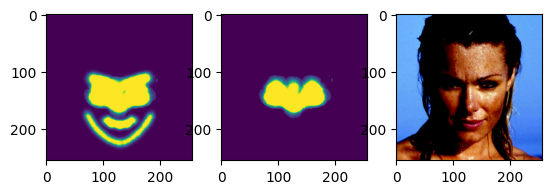

In [21]:
#check pretrained FAN
# root = "../dataset/data/celeba_hq/train"
root = "../shared/stargan_folder/data/celeba_hq/train"
train_loader = get_loader(root, params.batch_size, params.img_size, num_files=100)
train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y


masks = fan.get_heatmap(x_org)

plt.subplot(131)
plt.imshow(torch.permute(masks[0][0],[1,2,0]).cpu().detach().numpy())
plt.subplot(132)
plt.imshow(torch.permute(masks[1][0],[1,2,0]).cpu().detach().numpy())
plt.subplot(133)
plt.imshow(torch.permute(x_org[0],[1,2,0]).cpu().detach().numpy())
plt.show()

In [22]:
masks[1].shape

torch.Size([8, 1, 256, 256])

In [3]:
root = "../shared/stargan_folder/data/celeba_hq/train" #if gpu server
# root = "../shared/dataset/data/celeba_hq/train"
#Model,CopyModel = Model(params)

#restart gpu memory
#torch.cuda.empty_cache()
train_loader = get_loader(root, params.batch_size, params.img_size, num_files=100)
loaders = Munch(train=train_loader)
params.num_domains=len(train_loader.dataset.domains)

trainer = Trainer(params)



RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [16]:
len(train_loader.dataset.domains)

2

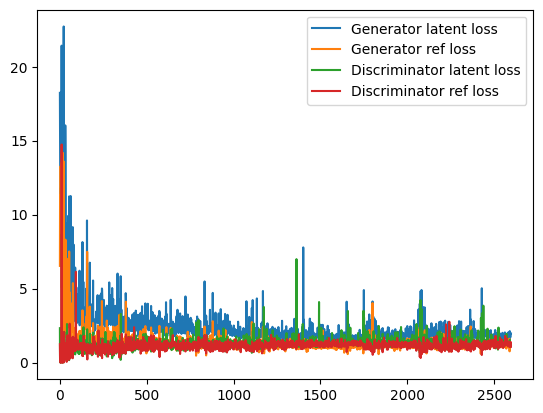

Time elapsed : 1:16:46.538827
Epoch : 200/200, Batch 10/13


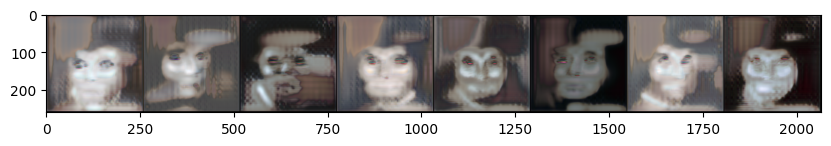

Checkpoint being saved at 000200_networs.cpt...
Checkpoint being saved at 000200__networs_copy.cpt...
Checkpoint being saved at 000200_optims.cpt...


In [17]:
trainer.train(loaders)

In [8]:
from torchvision.utils import make_grid

In [5]:
generator = trainer.networks_copy.generator
mn = trainer.networks_copy.mapping_network

train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

style = mn(z1,y_trg)
input_img=x_org
masks = fan.get_heatmap(input_img) if params.num_domains==2 else None
x_fake=generator(input_img,style,masks)

x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]
#normalize_tensor(x_fake)

grid = make_grid(x_n)



imgs=torch.permute(grid, [1,2,0]).cpu().detach().numpy()

#fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.imshow(imgs)
plt.show()


NameError: name 'trainer' is not defined

In [ ]:
x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]

#x_n = (x-x.min())/(x.max()-x.min())

x_n.max()

In [ ]:
#continue training from last iter = 1000
params.resume_iter=1000
params.max_iter=2000
params.lambda_ds=0.5 #
params

trainer=Trainer(params)
trainer.train(loaders)

In [ ]:
generator = trainer.networks_copy.generator
mn = trainer.networks_copy.mapping_network

train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

style = mn(z1,y_trg)
input_img=x_org

x_fake=generator(input_img,style)[0]

fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.imshow(fake_img)
plt.show()
